# Importazione librerie

In [14]:
import random
import numpy as np
from deap import base, creator, tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [15]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Lettura/generazione dati

In [16]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [17]:
data_inizio = '2021-01-09'
data_fine = '2023-12-03'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,31472.685547
2,2021-01-11,29247.208984
3,2021-01-12,27786.228516
4,2021-01-13,30682.929688
...,...,...
1054,2023-11-29,34379.074219
1055,2023-11-30,34499.992188
1056,2023-12-01,34625.015625
1057,2023-12-02,35518.437500


In [18]:
def calcola_rendimento_portafoglio_ideale(lista_prezzi, capitale_iniziale, bitcoin_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [19]:
def estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state):
    # Filtra i dati tra start_date e end_date
    dati_filtrati = dati[(dati['Timestamp'] >= pd.to_datetime(start_date)) & 
                         (dati['Timestamp'] <= pd.to_datetime(end_date))]
    
    # Calcola il numero massimo di periodi non sovrapposti
    num_max_periodi = len(dati_filtrati) - L + 1
    
    # Controlla se è possibile estrarre N periodi diversi
    if num_max_periodi < N:
        raise ValueError(f"Non è possibile estrarre {N} periodi diversi di lunghezza {L} tra le date {start_date} e {end_date}.")
    
    # Inizializza una lista per i periodi estratti e un set per memorizzare gli estremi
    periodi_estratti = []
    estremi_estratti = set()
    
    # Inizializza il generatore di numeri casuali con il seed dato
    rng = np.random.RandomState(random_state)
    
    while len(periodi_estratti) < N:
        # Seleziona un indice casuale per l'inizio del periodo
        indice_inizio = rng.randint(0, len(dati_filtrati) - L + 1)
        
        # Determina gli estremi del periodo
        estremo_inizio = dati_filtrati.iloc[indice_inizio]['Timestamp']
        estremo_fine = dati_filtrati.iloc[indice_inizio + L - 1]['Timestamp']
        
        # Controlla se gli estremi sono già stati utilizzati
        if (estremo_inizio, estremo_fine) not in estremi_estratti:
            # Aggiungi gli estremi al set
            estremi_estratti.add((estremo_inizio, estremo_fine))
            
            # Estrai il periodo e aggiungilo alla lista dei periodi estratti
            periodo = dati_filtrati.iloc[indice_inizio:indice_inizio + L]

            periodo = periodo.reset_index(drop=True)

            periodi_estratti.append(periodo)
    
    return periodi_estratti

In [20]:
# Esempio di utilizzo:
start_date = dati['Timestamp'].iloc[0]
end_date = dati['Timestamp'].iloc[-1]
N = 100 # Numero di periodi da estrarre
L = 60 # Lunghezza di ogni periodo in giorni
random_state = 8

In [21]:
periodi_casuali_esistenti = estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state)
print('Fattore di ritorno medio dei prezzi estratti:', np.mean([df['Price'].iloc[-1] / df['Price'].iloc[0] for df in periodi_casuali_esistenti]))

ideal_returns = [calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in periodi_casuali_esistenti]

print('Media dei fattori di rendimento massimi ottenibili:', np.mean(ideal_returns))

perc_suff = np.mean([1/calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in periodi_casuali_esistenti])

print(f'Punteggio percentuale considerato "sufficiente": {round(perc_suff*100,2)}%')

Fattore di ritorno medio dei prezzi estratti: 1.013055361501082
Media dei fattori di rendimento massimi ottenibili: 1.9023948148192946
Punteggio percentuale considerato "sufficiente": 55.57%


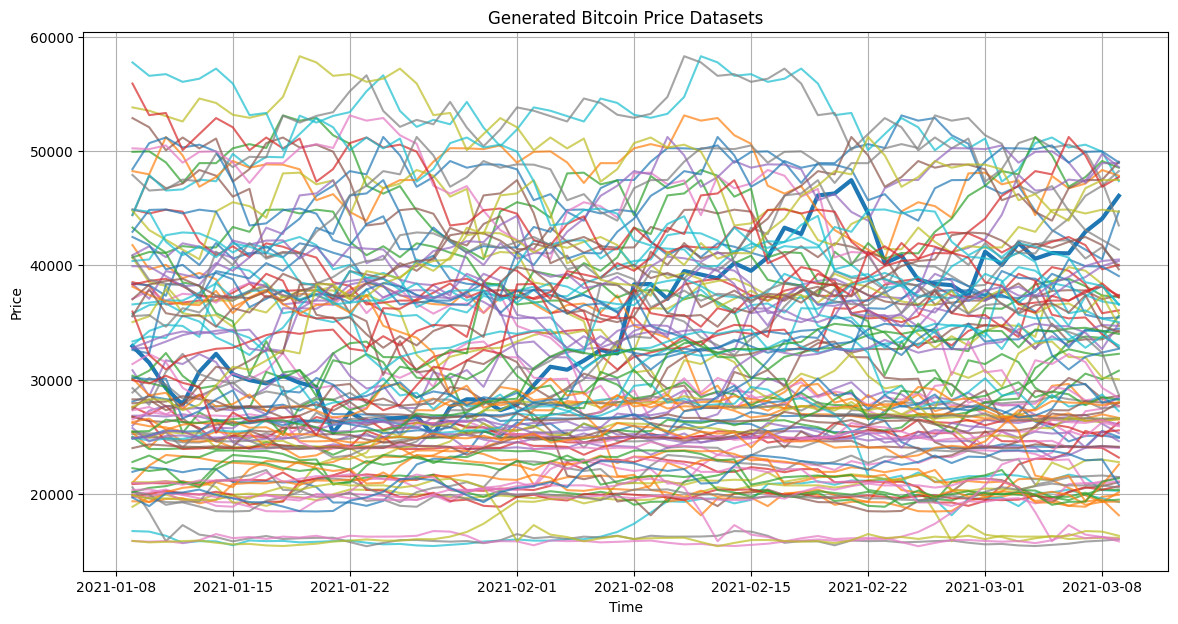

In [22]:
datasets = [periodi_casuali_esistenti[i]['Price'].values for i in range(len(periodi_casuali_esistenti))]

lunghezza_dataset = len(periodi_casuali_esistenti[0])

# Converte i dataset generati in DataFrame
generated_dfs = [pd.DataFrame({'Timestamp': dati['Timestamp'].iloc[:lunghezza_dataset], 'Price': prices}) for prices in datasets] # Fingo che le date siano tutte iniziate con data_inizio

# Plotting
plt.figure(figsize=(14, 7))

# Plot del dataset originale
plt.plot(dati['Timestamp'].iloc[:lunghezza_dataset], dati['Price'].iloc[:lunghezza_dataset].values, label='Original', linewidth=3)

# Plot dei dataset generati
for i, df in enumerate(generated_dfs):
    plt.plot(df['Timestamp'], df['Price'], label=f'Generated Dataset {i+1}', alpha=0.7)

plt.title('Generated Bitcoin Price Datasets')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.yscale('log')
plt.grid()
# plt.legend()
plt.show()

In [23]:
dati_da_usare = periodi_casuali_esistenti.copy()

In [24]:
dati_da_usare[0]

,Timestamp,Price
0,2022-04-05,41772.113281
1,2022-04-06,39647.105469
2,2022-04-07,40040.984375
3,2022-04-08,38879.828125
4,2022-04-09,39334.453125
5,2022-04-10,38778.593750
6,2022-04-11,36335.328125
7,2022-04-12,37065.078125
8,2022-04-13,37784.144531
9,2022-04-14,36902.015625


# Algoritmo genetico

In [25]:
# Funzione per calcolare l'ultimo prezzo di riferimento discesa
def calcola_prezzo_riferimento_discesa(dati, soglia_discesa):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente < 1:  # Prezzo in discesa
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if variazione_cumulata - 1 >= soglia_discesa:
                # Se la variazione supera la soglia, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

# Funzione per calcolare l'ultimo prezzo di riferimento salita
def calcola_prezzo_riferimento_salita(dati, soglia_salita):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente > 1:  # Prezzo in salita
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if 1 - variazione_cumulata >= soglia_salita:
                # Se la variazione supera la soglia o il prezzo di riferimento è superiore al prezzo attuale, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

def calcola_percentuale(variazione, coefficienti, A, B):
    if isinstance(coefficienti, list):
        # Se coefficienti è una lista, esegue la somma ponderata delle variazioni
        return min(max(sum([c * variazione ** i for i, c in enumerate(coefficienti)]), 0), 1)
    
    elif isinstance(coefficienti, str) and coefficienti != 'custom_exp':
        # Se coefficienti è una stringa, interpreta la stringa come una formula matematica
        # Sostituisci 'x' con il valore di variazione
        formula = coefficienti.replace('x', str(variazione))
        # Usa eval per calcolare il risultato
        try:
            risultato = eval(formula)
        except Exception as e:
            raise ValueError(f"Errore nell'interpretazione della formula: {e}")
        return min(max(risultato, 0), 1)
    
    elif coefficienti == 'custom_exp':
        return eval(f'variazione ** {A} / ({B} + (1 - {B}) * variazione ** {A})')
    
    else:
        raise TypeError("Il parametro 'coefficienti' deve essere una lista, una stringa o 'custom_exp'.")

In [26]:
def trading_perc_senza_micro_variazioni_velocizzato(dati, inverti_riferimento_acquisto, inverti_riferimento_vendita, acquisto_rispetto_liquidità_iniziale, vendita_rispetto_massimo_btc_posseduti,
     compra_pure, vendi_pure, soglia_vendita, A_a, B_a, A_v, B_v, coefficienti_acquisto, coefficienti_vendita,
     compra_solo_in_discesa, vendi_solo_in_salita, soglia_acquisto_rispetto_riferimento,
     soglia_vendita_rispetto_riferimento, soglia_calcolo_variazioni_discesa, soglia_calcolo_variazioni_salita, perc_relativa, finestra_minimo, finestra_massimo, nuovi_min_all_in, nuovi_max_all_in, soglia_acquisti_vicini, soglia_vendite_vicine, liquidità_iniziale, bitcoin_iniziali):
    

    # Parametri iniziali
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    valore_totale_portafoglio = liquidità + bitcoin * dati['Price'][0]

    # Calcolo variazioni giornaliere
    dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

    # Inizializza la lista delle transazioni
    transazioni = []

    # Variabili per tenere traccia degli acquisti consecutivi
    acquisti_consecutivi = []
    quantità_euro_totale = 0  # Somma totale degli euro spesi negli acquisti consecutivi

    liquidità_iniziale_in_btc = liquidità_iniziale / dati['Price'].iloc[0]

    ultimo_prezzo_acquisto = None
    ultimo_prezzo_vendita = None
    ultima_azione = None
    azione = None


    # Simulazione del trading giorno per giorno
    for i in range(1, len(dati)):
        data_odierna = dati['Timestamp'].iloc[i]
        prezzo_attuale = dati['Price'].iloc[i]
        variazione_giornaliera_prezzo_percentuale = (dati['Variazione'].iloc[i] - 1) * 100
        if perc_relativa:
            if finestra_minimo <= i:
                minimo_ultimi_giorni = np.min(dati['Price'].iloc[i-finestra_minimo:i+1])

            else:
                minimo_ultimi_giorni = np.min(dati['Price'].iloc[:i+1])

            if finestra_massimo <= i:
                massimo_ultimi_giorni = np.max(dati['Price'].iloc[i-finestra_massimo:i+1])

            else:
                massimo_ultimi_giorni = np.max(dati['Price'].iloc[:i+1])
        
        # Calcola i prezzi di riferimento discesa e salita
        timestamp_riferimento_discesa, prezzo_riferimento_discesa = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)
        timestamp_riferimento_salita, prezzo_riferimento_salita = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)
        # timestamp_riferimento_discesa, prezzo_riferimento_discesa = rif_discesa_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_discesa)
        # timestamp_riferimento_salita, prezzo_riferimento_salita = rif_salita_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_salita)

        # Scegli il prezzo di riferimento più recente (se esiste)
        prezzo_riferimento = None
        if prezzo_riferimento_discesa is not None and prezzo_riferimento_salita is not None:
            if timestamp_riferimento_discesa > timestamp_riferimento_salita:
                prezzo_riferimento = prezzo_riferimento_discesa
                tipo_riferimento = 'discesa'
            else:
                prezzo_riferimento = prezzo_riferimento_salita
                tipo_riferimento = 'salita'
        elif prezzo_riferimento_discesa is not None:
            prezzo_riferimento = prezzo_riferimento_discesa
            tipo_riferimento = 'discesa'
        elif prezzo_riferimento_salita is not None:
            prezzo_riferimento = prezzo_riferimento_salita
            tipo_riferimento = 'salita'

        # Se nessun riferimento è disponibile, passa al giorno successivo
        if prezzo_riferimento is None:
            continue

        # Variabili per tracciare l'azione e la transazione
        azione = '-'
        # percentuale_liquidità_usata = 0
        # percentuale_bitcoin_usata = 0
        # percentuale_liquidità_usata_rispetto_rif = 0
        # percentuale_bitcoin_usata_rispetto_rif = 0
        # euro_spesi_o_ricavati = 0
        # bitcoin_acquistati_o_venduti = 0

        # Logica di acquisto o vendita in base al riferimento più recente
        if tipo_riferimento == 'discesa':  # Logica di acquisto
            if not perc_relativa:
                if inverti_riferimento_acquisto:
                    variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
                else:
                    variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
            else:
                den = prezzo_riferimento_discesa - minimo_ultimi_giorni
                if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il minimo sia superiore all'ultimo prezzo_riferimento_discesa salvato
                    num = prezzo_riferimento_discesa - prezzo_attuale
                    variazione_percentuale = num / den
                    if not nuovi_min_all_in and variazione_percentuale == 1:
                        if inverti_riferimento_acquisto:
                            variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
                        else:
                            variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
                else:
                    variazione_percentuale = 0


            percentuale_acquisto = calcola_percentuale(abs(variazione_percentuale), coefficienti_acquisto, A_a, B_a)
            liquidità_da_usare = liquidità_iniziale if acquisto_rispetto_liquidità_iniziale else liquidità
            euro_da_spendere = liquidità_da_usare * percentuale_acquisto

            if euro_da_spendere > liquidità:
                if compra_pure:
                    euro_da_spendere = liquidità  # Usa tutto
                else:
                    euro_da_spendere = 0  # Non fare niente

            if euro_da_spendere > 0 and (compra_solo_in_discesa and variazione_giornaliera_prezzo_percentuale < 0 or not compra_solo_in_discesa) and prezzo_attuale < prezzo_riferimento_discesa * (1 - soglia_acquisto_rispetto_riferimento) and (soglia_acquisti_vicini > 0 and ultimo_prezzo_acquisto is not None and ultima_azione == 'Acquisto' and abs(prezzo_attuale - ultimo_prezzo_acquisto) >= soglia_acquisti_vicini * ultimo_prezzo_acquisto or soglia_acquisti_vicini == 0 or ultima_azione is None):
                # percentuale_liquidità_usata = euro_da_spendere / liquidità
                bitcoin_acquistati = euro_da_spendere / prezzo_attuale
                liquidità -= euro_da_spendere
                bitcoin += bitcoin_acquistati
                azione = 'Acquisto'
                ultima_azione = azione
                # percentuale_liquidità_usata_rispetto_rif = percentuale_acquisto
                # euro_spesi_o_ricavati = euro_da_spendere
                # bitcoin_acquistati_o_venduti = bitcoin_acquistati
                
                # Aggiungi questo acquisto alla lista degli acquisti consecutivi
                acquisti_consecutivi.append((prezzo_attuale, euro_da_spendere))
                quantità_euro_totale += euro_da_spendere
                ultimo_prezzo_acquisto = prezzo_attuale

        elif tipo_riferimento == 'salita':  # Logica di vendita
            if not perc_relativa:
                if inverti_riferimento_vendita:
                    variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
                else:
                    variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
            else:
                den = massimo_ultimi_giorni - prezzo_riferimento_salita
                if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il massimo sia inferiore all'ultimo prezzo_riferimento_salita salvato
                    num = prezzo_attuale - prezzo_riferimento_salita
                    variazione_percentuale = num / den
                    if not nuovi_max_all_in and variazione_percentuale == 1:
                        if inverti_riferimento_vendita:
                            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
                        else:
                            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
                else:
                    variazione_percentuale = 0

            percentuale_vendita = calcola_percentuale(abs(variazione_percentuale), coefficienti_vendita, A_v, B_v)
            bitcoin_da_usare = liquidità_iniziale_in_btc if vendita_rispetto_massimo_btc_posseduti else bitcoin
            bitcoin_da_vendere = bitcoin_da_usare * percentuale_vendita


            # Controllo del prezzo di vendita rispetto alla media pesata degli acquisti consecutivi
            if acquisti_consecutivi:
                # Calcolo della media pesata dei prezzi di acquisto
                somma_pesata = sum(prezzo * euro for prezzo, euro in acquisti_consecutivi)
                media_pesata_acquisti = somma_pesata / quantità_euro_totale

                # Verifica che il prezzo attuale sia superiore alla soglia rispetto alla media pesata
                if prezzo_attuale <= media_pesata_acquisti * (1 + soglia_vendita):
                    # Se non soddisfa la soglia di vendita, non fare niente
                    bitcoin_da_vendere = 0

            if bitcoin_da_vendere > bitcoin:
                if vendi_pure:
                    bitcoin_da_vendere = bitcoin  # Vendi tutto
                else:
                    bitcoin_da_vendere = 0  # Non fare niente

            if bitcoin_da_vendere > 0 and (vendi_solo_in_salita and variazione_giornaliera_prezzo_percentuale > 0 or not vendi_solo_in_salita) and prezzo_attuale > prezzo_riferimento_salita * (1 + soglia_vendita_rispetto_riferimento) and (soglia_vendite_vicine > 0 and ultimo_prezzo_vendita is not None and ultima_azione == 'Vendita' and abs(prezzo_attuale - ultimo_prezzo_vendita) >= soglia_vendite_vicine * ultimo_prezzo_vendita or soglia_vendite_vicine == 0 or ultima_azione is None):
                # percentuale_bitcoin_usata = bitcoin_da_vendere / bitcoin
                euro_ricavati = bitcoin_da_vendere * prezzo_attuale
                bitcoin -= bitcoin_da_vendere
                liquidità += euro_ricavati
                azione = 'Vendita'
                ultima_azione = azione
                # percentuale_bitcoin_usata_rispetto_rif = percentuale_vendita
                # euro_spesi_o_ricavati = euro_ricavati
                # bitcoin_acquistati_o_venduti = bitcoin_da_vendere

                # Reset degli acquisti consecutivi dopo una vendita
                acquisti_consecutivi = []
                quantità_euro_totale = 0
                ultimo_prezzo_vendita = prezzo_attuale


        # Aggiorna il valore totale del portafoglio
        valore_totale_portafoglio = liquidità + (bitcoin * prezzo_attuale)

        # variazione_perc_rispetto_riferimento_discesa = (prezzo_attuale / prezzo_riferimento_discesa - 1) * 100 if prezzo_riferimento_discesa else None
        # variazione_perc_rispetto_riferimento_salita = (prezzo_attuale / prezzo_riferimento_salita - 1) * 100 if prezzo_riferimento_salita else None

        # Salva la transazione nella lista
        nuova_transazione = {
            # 'data': data_odierna,
            'prezzo': prezzo_attuale,
            # 'variazione_giornaliera_prezzo_percentuale': round(variazione_giornaliera_prezzo_percentuale, 2),
            # 'timestamp_riferimento_discesa': timestamp_riferimento_discesa,
            # 'prezzo_riferimento_discesa': prezzo_riferimento_discesa,
            # 'variazione_rispetto_riferimento_discesa': round((prezzo_attuale / prezzo_riferimento_discesa - 1) * 100, 2) if prezzo_riferimento_discesa else None,
            # 'timestamp_riferimento_salita': timestamp_riferimento_salita,
            # 'prezzo_riferimento_salita': prezzo_riferimento_salita,
            # 'variazione_rispetto_riferimento_salita': round((prezzo_attuale / prezzo_riferimento_salita - 1) * 100, 2) if prezzo_riferimento_salita else None,
            # 'azione': azione,
            # 'percentuale_liquidità_usata': percentuale_liquidità_usata,
            # 'percentuale_bitcoin_usata': percentuale_bitcoin_usata,
            # 'quantità_euro': euro_spesi_o_ricavati,
            # 'bitcoin_acquistati_o_venduti': bitcoin_acquistati_o_venduti,
            # 'liquidità': liquidità,
            'bitcoin': bitcoin,
            'valore_totale_portafoglio': valore_totale_portafoglio
        }
        transazioni.append(nuova_transazione)

    # Crea il DataFrame delle transazioni alla fine
    df_transazioni = pd.DataFrame(transazioni)

    return df_transazioni

In [42]:
# # Definizione dello spazio dei parametri di ricerca
# # IMPORTANTE: INDICARE LE VARIABILI REALI CON LA VIRGOLA E QUELLE INTERE SENZA VIRGOLA
# space = {
#     'inverti_riferimento_acquisto': [True],
#     'inverti_riferimento_vendita': [True],
#     'acquisto_rispetto_liquidità_iniziale': [True],
#     'vendita_rispetto_massimo_btc_posseduti': [True],
#     'compra_pure': [True],
#     'vendi_pure': [True],
#     'soglia_vendita': (-1.0, 1.0),  # Real
#     'A_a': (0.1, 15),  # Real
#     'B_a': (0.001, 5),  # Real
#     'A_v': (0.1, 15),  # Real
#     'B_v': (0.001, 5),  # Real
#     'coefficienti_acquisto': ['custom_exp'],
#     'coefficienti_vendita': ['custom_exp'],
#     'compra_solo_in_discesa': [True],
#     'vendi_solo_in_salita': [False],
#     'soglia_acquisto_rispetto_riferimento': (0.0, 1.0),  # Real
#     'soglia_vendita_rispetto_riferimento': (0.0, 1.0),  # Real
#     'soglia_calcolo_variazioni_discesa': (0.0, 0.5),  # Real
#     'soglia_calcolo_variazioni_salita': (0.0, 0.5),  # Real
#     'perc_relativa': [True, False],
#     'finestra_minimo': (2, len(dati_da_usare[0])), # Int
#     'finestra_massimo': (2, len(dati_da_usare[0])), # Int
#     'nuovi_min_all_in': [True, False],
#     'nuovi_max_all_in': [True, False],
#     'soglia_acquisti_vicini': (0.0, 0.15), # Real
#     'soglia_vendite_vicine': (0.0, 0.15) # Real
# }

# # Imposta parametri di configurazione dell'algoritmo genetico
# population_size = 100          # Numero di individui nella popolazione iniziale
# elite_size = 10                # Numero di individui élite da mantenere
# crossover_probability = 0.5    # Probabilità di crossover
# mutation_probability = 0.2     # Probabilità di mutazione
# tournament_size = 3            # Numero di individui partecipanti a ogni torneo di selezione
# crossover_type = 'uniform'     # Tipo di crossover: 'single-point', 'two-point', 'uniform'
# indpb = [0.5] * len(space)             # Lista di probabilità di mutazione per ogni parametro
# selection_method = "custom"    # Selettore: "tournament", "roulette_wheel", "custom"
# elitism_method = "reduce"      # Metodo di elitismo: "reduce" o altro
# optimize_direction = "maximize"  # Direzione di ottimizzazione: "minimize" o "maximize"
# offspring_ratio = 1.0          # Rapporto di sostituzione dei figli rispetto alla popolazione (di default 1.0)
# patience = None                # Numero di generazioni senza miglioramenti prima di fermarsi
# num_generations = 10           # Numero di generazioni totali, se `patience=None`

# random_seed = 42               # Seme per la riproducibilità dei risultati
# use_stats = True               # Raccogliere le statistiche durante l'evoluzione
# verbosity = True               # Se True, mostrare output di ogni generazione

# # Definisci i parametri fissi
# parametri_fissi = {
#     'liquidità_iniziale': 1000,
#     'bitcoin_iniziali': 0
# }

# # Variabili globali per tenere traccia delle migliori e peggiori coppie
# best_pair = {'score': -np.inf, 'params': None, 'dataset': None}
# worst_pair = {'score': np.inf, 'params': None, 'dataset': None}

# # Funzione che crea un individuo in base allo space definito
# def create_individual():
#     individual = []
#     for param, values in space.items():
#         if isinstance(values, list):
#             # Variabile categorica o booleana
#             individual.append(random.choice(values))
#         elif isinstance(values[0], int):
#             # Variabile intera
#             individual.append(random.randint(*values))
#         else:
#             # Variabile reale
#             individual.append(random.uniform(*values))
#     return individual

# # Funzione di valutazione (funzione obiettivo)
# def eval_individual(individual, gen):
#     global best_pair, worst_pair
    
#     params = {key: individual[i] for i, key in enumerate(space.keys())}
#     scores = []
#     for i, df in enumerate(dati_da_usare):
#         transactions = trading_perc_senza_micro_variazioni_velocizzato(df, **{**params, **parametri_fissi})
#         portfolio_values = transactions['valore_totale_portafoglio']
#         total_return_factor = portfolio_values.iloc[-1] / portfolio_values.iloc[0]
#         ideal_return = calcola_rendimento_portafoglio_ideale(df['Price'], *[parametri_fissi[key] for key in parametri_fissi.keys()])[0]
#         score = total_return_factor / ideal_return
#         scores.append(score)
    
#     avg_score = np.mean(scores)

#     # Stampa le informazioni sull'individuo e il suo punteggio
#     print(f"Generation {gen}:\nIndividual: {individual}:\nScore: {avg_score}\n\n")

#     # Aggiorna best_pair e worst_pair
#     if avg_score > best_pair['score']:
#         best_pair = {'score': avg_score, 'params': params.copy(), 'dataset': i}
#     if avg_score < worst_pair['score']:
#         worst_pair = {'score': avg_score, 'params': params.copy(), 'dataset': i}

#     return (avg_score,)  # Restituisci la media dei punteggi

# # Funzione di selezione personalizzata
# def custom_selection(population, k, tournsize, optimize_direction):
#     """Selezione personalizzata che combina la selezione a torneo con la roulette wheel."""
#     chosen = []
#     for _ in range(k):
#         # Selezioniamo un sottoinsieme di `tournsize` individui, pesati per la loro fitness
#         selected = tools.selRoulette(population, tournsize)  # Roulette per selezionare `tournsize` individui
#         # Selezioniamo il migliore o il peggiore a seconda della direzione di ottimizzazione
#         if optimize_direction == "maximize":
#             chosen.append(max(selected, key=lambda ind: ind.fitness.values[0]))  # Miglior individuo vince il torneo
#         else:  # Se minimizziamo
#             chosen.append(min(selected, key=lambda ind: ind.fitness.values[0]))  # Peggior individuo (in minimizzazione)
#     return chosen

# # Definizione del tipo di fitness e dell'individuo
# if optimize_direction == "maximize":
#     creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Massimizzazione
# else:
#     creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizzazione

# creator.create("Individual", list, fitness=creator.FitnessMax if optimize_direction == "maximize" else creator.FitnessMin)

# # Funzione per la mutazione personalizzata
# def mutate_individual(individual, indpb):
#     """Applica la mutazione in base al tipo di parametro e a `indpb` per ogni gene."""
#     for i, (key, values) in enumerate(space.items()):
#         if random.random() < indpb[i]:  # Usa `indpb` specifica per quel parametro
#             if isinstance(values, list):  # Variabile categorica o booleana
#                 individual[i] = random.choice(values)
#             elif isinstance(values[0], int):  # Variabile intera
#                 individual[i] = random.randint(*values)
#             else:  # Variabile reale
#                 individual[i] = random.uniform(*values)
#     return individual,

# # Crea la toolbox e registra le funzioni per l'algoritmo genetico
# toolbox = base.Toolbox()
# toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# toolbox.register("evaluate", eval_individual)
# toolbox.register("mutate", mutate_individual, indpb=indpb)

# def custom_cx_uniform(ind1, ind2, indpb):
#     """Esegue un crossover uniforme che può gestire una lista di probabilità."""
#     size = min(len(ind1), len(ind2))
#     for i in range(size):
#         if random.random() < indpb[i]:
#             ind1[i], ind2[i] = ind2[i], ind1[i]
#     return ind1, ind2

# # Selezione: Usa il metodo selezionato dall'utente
# if selection_method == "roulette_wheel":
#     toolbox.register("select", tools.selRoulette)
# elif selection_method == "tournament":
#     toolbox.register("select", tools.selTournament, tournsize=tournament_size)
# elif selection_method == "custom":
#     toolbox.register("select", custom_selection, tournsize=tournament_size, optimize_direction=optimize_direction)
# else:
#     raise ValueError("selection_method deve essere 'tournament', 'roulette_wheel' o 'custom'.")

# # Impostazione del crossover in base al tipo scelto
# if crossover_type == 'single-point':
#     toolbox.register("mate", tools.cxOnePoint)
# elif crossover_type == 'two-point':
#     toolbox.register("mate", tools.cxTwoPoint)
# elif crossover_type == 'uniform':
#     toolbox.register("mate", custom_cx_uniform, indpb=indpb)  # Crossover uniforme con probabilità di scambio 'indpb'

# # Se vuoi raccogliere le statistiche
# if use_stats:
#     stats = tools.Statistics(lambda ind: ind.fitness.values)
#     stats.register("avg", np.mean)
#     stats.register("std", np.std)
#     stats.register("min", np.min)
#     stats.register("max", np.max)
# else:
#     stats = None

# # Funzione per applicare la logica di patience
# def patience_callback(population, hof, patience, best_fitness, patience_counter):
#     current_best = tools.selBest(population, k=1)[0].fitness.values[0]
#     if optimize_direction == "maximize":
#         improvement_condition = current_best > best_fitness
#     else:
#         improvement_condition = current_best < best_fitness
    
#     if improvement_condition:
#         best_fitness = current_best
#         patience_counter = 0
#         print(f"New best fitness: {best_fitness}")
#     else:
#         patience_counter += 1
#         print(f"No improvement, patience counter: {patience_counter}")
#     return best_fitness, patience_counter

# # Funzione principale per eseguire l'algoritmo genetico
# def run_genetic_algorithm(population_size, ngen, patience):
#     population = toolbox.population(n=population_size)
#     hof = tools.HallOfFame(1)
#     best_fitness = -np.inf if optimize_direction == "maximize" else np.inf
#     patience_counter = 0

#     # Valutazione degli individui iniziali
#     invalid_ind = [ind for ind in population if not ind.fitness.valid]
#     fitnesses = [toolbox.evaluate(ind, gen=0) for ind in invalid_ind]  # Generazione 0
#     for ind, fit in zip(invalid_ind, fitnesses):
#         ind.fitness.values = fit

#     for gen in range(ngen):
#         # Seleziona i genitori in base a elitism_method
#         if elitism_method == "reduce":
#             # Metodo elitismo "reduce": selezioniamo meno genitori per fare spazio agli élite
#             offspring = toolbox.select(population, int(len(population) * offspring_ratio) - elite_size)
#         else:
#             # Metodo elitismo standard: selezioniamo l'intera popolazione
#             offspring = toolbox.select(population, int(len(population) * offspring_ratio))

#         # Applicare crossover e mutazione agli individui selezionati
#         offspring = list(map(toolbox.clone, offspring))
#         for child1, child2 in zip(offspring[::2], offspring[1::2]):
#             if random.random() < crossover_probability:
#                 toolbox.mate(child1, child2)
#                 del child1.fitness.values
#                 del child2.fitness.values
#         for mutant in offspring:
#             if random.random() < mutation_probability:
#                 toolbox.mutate(mutant)
#                 del mutant.fitness.values

#         # Valutazione degli individui alterati
#         invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
#         fitnesses = [toolbox.evaluate(ind, gen=gen) for ind in invalid_ind]  # Generazione corrente
#         for ind, fit in zip(invalid_ind, fitnesses):
#             ind.fitness.values = fit

#         # Aggiorna popolazione con élite
#         if elitism_method == "reduce":
#             # Metodo "reduce": Aggiungiamo semplicemente gli élite alla popolazione
#             offspring.extend(map(toolbox.clone, tools.selBest(population, elite_size)))
#         else:
#             # Metodo standard: Sostituiamo i peggiori individui con gli élite
#             reverse_sort = (optimize_direction == "maximize")
#             offspring.sort(key=lambda ind: ind.fitness.values[0], reverse=reverse_sort)
#             offspring[-elite_size:] = map(toolbox.clone, tools.selBest(population, elite_size))

#         population[:] = offspring

#         # Statistiche opzionali
#         if stats:
#             record = stats.compile(population)
#             print(f"Stats for generation {gen}: {record}")

#         # Verbosità opzionale
#         if verbosity:
#             best_individual = tools.selBest(population, k=1)[0]
#             print(f"Generation {gen}: Best fitness {best_individual.fitness.values[0]}")
#             print(f"Best individual: {best_individual}")

#         # Controlla se il patience è impostato
#         if patience is not None:
#             best_fitness, patience_counter = patience_callback(population, hof, patience, best_fitness, patience_counter)
#             if patience_counter >= patience:
#                 print("Patience limit reached, stopping evolution.")
#                 break

In [49]:
def format_params_2(params, names):
    return ", ".join(f"{key} = {value}" for key, value in zip(names, params))

In [58]:
import random
import numpy as np
from deap import base, creator, tools

# Definizione dello spazio dei parametri di ricerca
# IMPORTANTE: INDICARE LE VARIABILI REALI CON LA VIRGOLA E QUELLE INTERE SENZA VIRGOLA
space = {
    'inverti_riferimento_acquisto': [True],
    'inverti_riferimento_vendita': [True],
    'acquisto_rispetto_liquidità_iniziale': [True],
    'vendita_rispetto_massimo_btc_posseduti': [True],
    'compra_pure': [True],
    'vendi_pure': [True],
    'soglia_vendita': (-1.0, 1.0),  # Real
    'A_a': (0.1, 15),  # Real
    'B_a': (0.001, 5),  # Real
    'A_v': (0.1, 15),  # Real
    'B_v': (0.001, 5),  # Real
    'coefficienti_acquisto': ['custom_exp'],
    'coefficienti_vendita': ['custom_exp'],
    'compra_solo_in_discesa': [True],
    'vendi_solo_in_salita': [False],
    'soglia_acquisto_rispetto_riferimento': (0.0, 1.0),  # Real
    'soglia_vendita_rispetto_riferimento': (0.0, 1.0),  # Real
    'soglia_calcolo_variazioni_discesa': (0.0, 0.5),  # Real
    'soglia_calcolo_variazioni_salita': (0.0, 0.5),  # Real
    'perc_relativa': [True, False],
    'finestra_minimo': (2, len(dati_da_usare[0])), # Int
    'finestra_massimo': (2, len(dati_da_usare[0])), # Int
    'nuovi_min_all_in': [True, False],
    'nuovi_max_all_in': [True, False],
    'soglia_acquisti_vicini': (0.0, 0.15), # Real
    'soglia_vendite_vicine': (0.0, 0.15) # Real
}

# Imposta parametri di configurazione dell'algoritmo genetico
population_size = 100          # Numero di individui nella popolazione iniziale
elite_size = 10                # Numero di individui élite da mantenere
crossover_probability = 0.5    # Probabilità di crossover
mutation_probability = 0.2     # Probabilità di mutazione
tournament_size = 8            # Numero di individui partecipanti a ogni torneo di selezione
crossover_type = 'uniform'     # Tipo di crossover: 'single-point', 'two-point', 'uniform'
indpb = [0.5] * len(space)             # Lista di probabilità di mutazione per ogni parametro
selection_method = "custom"    # Selettore: "tournament", "roulette_wheel", "custom"
elitism_method = "reduce"      # Metodo di elitismo: "reduce" o altro
optimize_direction = "maximize"  # Direzione di ottimizzazione: "minimize" o "maximize"
offspring_ratio = 1.0          # Rapporto di sostituzione dei figli rispetto alla popolazione (di default 1.0)
patience = None                # Numero di generazioni senza miglioramenti prima di fermarsi
num_generations = 30           # Numero di generazioni totali, se `patience=None`

random_seed = 42               # Seme per la riproducibilità dei risultati
use_stats = True               # Raccogliere le statistiche durante l'evoluzione
verbosity = True               # Se True, mostrare output di ogni generazione

random.seed(random_seed)
np.random.seed(random_seed)

# Definisci i parametri fissi
parametri_fissi = {
    'liquidità_iniziale': 1000,
    'bitcoin_iniziali': 0
}

# Variabili globali per tenere traccia delle migliori e peggiori coppie
best_pair = {'score': -np.inf, 'params': None, 'dataset': None}
worst_pair = {'score': np.inf, 'params': None, 'dataset': None}

# Funzione che crea un individuo in base allo space definito
def create_individual():
    individual = []
    for param, values in space.items():
        if isinstance(values, list):
            # Variabile categorica o booleana
            individual.append(random.choice(values))
        elif isinstance(values[0], int):
            # Variabile intera
            individual.append(random.randint(*values))
        else:
            # Variabile reale
            individual.append(random.uniform(*values))
    return individual

# Funzione di valutazione (funzione obiettivo)
def eval_individual(individual, gen, individual_index):
    global best_pair, worst_pair

    params = {key: individual[i] for i, key in enumerate(space.keys())}
    scores = []
    for i, df in enumerate(dati_da_usare):
        transactions = trading_perc_senza_micro_variazioni_velocizzato(df, **{**params, **parametri_fissi})
        portfolio_values = transactions['valore_totale_portafoglio']
        total_return_factor = portfolio_values.iloc[-1] / portfolio_values.iloc[0]
        ideal_return = calcola_rendimento_portafoglio_ideale(df['Price'], *[parametri_fissi[key] for key in parametri_fissi.keys()])[0]
        score = total_return_factor / ideal_return
        scores.append(score)

    avg_score = np.mean(scores)

    # Stampa le informazioni sull'individuo e il suo punteggio
    print(f"Generation {gen}:\nIndividual {individual_index+1} of {population_size}: {format_params_2(individual, space.keys())}:\nScore: {avg_score}\n\n")

    # Aggiorna best_pair e worst_pair
    if avg_score > best_pair['score']:
        best_pair = {'score': avg_score, 'params': params.copy(), 'dataset': i}
    if avg_score < worst_pair['score']:
        worst_pair = {'score': avg_score, 'params': params.copy(), 'dataset': i}

    return (avg_score,)  # Restituisci la media dei punteggi

# Funzione di selezione personalizzata
def custom_selection(population, k, tournsize, optimize_direction):
    """Selezione personalizzata che combina la selezione a torneo con la roulette wheel."""
    chosen = []
    for _ in range(k):
        # Selezioniamo un sottoinsieme di `tournsize` individui, pesati per la loro fitness
        selected = tools.selRoulette(population, tournsize)  # Roulette per selezionare `tournsize` individui
        # Selezioniamo il migliore o il peggiore a seconda della direzione di ottimizzazione
        if optimize_direction == "maximize":
            chosen.append(max(selected, key=lambda ind: ind.fitness.values[0]))  # Miglior individuo vince il torneo
        else:  # Se minimizziamo
            chosen.append(min(selected, key=lambda ind: ind.fitness.values[0]))  # Peggior individuo (in minimizzazione)
    return chosen

# Definizione del tipo di fitness e dell'individuo
if optimize_direction == "maximize":
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Massimizzazione
else:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizzazione

creator.create("Individual", list, fitness=creator.FitnessMax if optimize_direction == "maximize" else creator.FitnessMin)

# Funzione per la mutazione personalizzata
def mutate_individual(individual, indpb):
    """Applica la mutazione in base al tipo di parametro e a `indpb` per ogni gene."""
    for i, (key, values) in enumerate(space.items()):
        if random.random() < indpb[i]:  # Usa `indpb` specifica per quel parametro
            if isinstance(values, list):  # Variabile categorica o booleana
                individual[i] = random.choice(values)
            elif isinstance(values[0], int):  # Variabile intera
                individual[i] = random.randint(*values)
            else:  # Variabile reale
                individual[i] = random.uniform(*values)
    return individual,

# Crea la toolbox e registra le funzioni per l'algoritmo genetico
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_individual)
toolbox.register("mutate", mutate_individual, indpb=indpb)

def custom_cx_uniform(ind1, ind2, indpb):
    """Esegue un crossover uniforme che può gestire una lista di probabilità."""
    size = min(len(ind1), len(ind2))
    for i in range(size):
        if random.random() < indpb[i]:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

# Selezione: Usa il metodo selezionato dall'utente
if selection_method == "roulette_wheel":
    toolbox.register("select", tools.selRoulette)
elif selection_method == "tournament":
    toolbox.register("select", tools.selTournament, tournsize=tournament_size)
elif selection_method == "custom":
    toolbox.register("select", custom_selection, tournsize=tournament_size, optimize_direction=optimize_direction)
else:
    raise ValueError("selection_method deve essere 'tournament', 'roulette_wheel' o 'custom'.")

# Impostazione del crossover in base al tipo scelto
if crossover_type == 'single-point':
    toolbox.register("mate", tools.cxOnePoint)
elif crossover_type == 'two-point':
    toolbox.register("mate", tools.cxTwoPoint)
elif crossover_type == 'uniform':
    toolbox.register("mate", custom_cx_uniform, indpb=indpb)  # Crossover uniforme con probabilità di scambio 'indpb'

# Se vuoi raccogliere le statistiche
if use_stats:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
else:
    stats = None

# Funzione per applicare la logica di patience
def patience_callback(population, hof, patience, best_fitness, patience_counter):
    current_best = tools.selBest(population, k=1)[0].fitness.values[0]
    if optimize_direction == "maximize":
        improvement_condition = current_best > best_fitness
    else:
        improvement_condition = current_best < best_fitness

    if improvement_condition:
        best_fitness = current_best
        patience_counter = 0
        print(f"New best fitness: {best_fitness}")
    else:
        patience_counter += 1
        print(f"No improvement, patience counter: {patience_counter}")
    return best_fitness, patience_counter

# Funzione principale per eseguire l'algoritmo genetico
def run_genetic_algorithm(population_size, ngen, patience):
    population = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    best_fitness = -np.inf if optimize_direction == "maximize" else np.inf
    patience_counter = 0

    # Valutazione degli individui iniziali
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(ind, gen=0, individual_index=i) for i, ind in enumerate(invalid_ind)]  # Generazione 0
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    for gen in range(ngen):
        # Seleziona i genitori in base a elitism_method
        if elitism_method == "reduce":
            # Metodo elitismo "reduce": selezioniamo meno genitori per fare spazio agli élite
            offspring = toolbox.select(population, int(len(population) * offspring_ratio) - elite_size)
        else:
            # Metodo elitismo standard: selezioniamo l'intera popolazione
            offspring = toolbox.select(population, int(len(population) * offspring_ratio))

        # Applicare crossover e mutazione agli individui selezionati
        offspring = list(map(toolbox.clone, offspring))
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < crossover_probability:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < mutation_probability:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Valutazione degli individui alterati
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = [toolbox.evaluate(ind, gen=gen, individual_index=i) for i, ind in enumerate(invalid_ind)]  # Generazione corrente
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Aggiorna popolazione con élite
        if elitism_method == "reduce":
            # Metodo "reduce": Aggiungiamo semplicemente gli élite alla popolazione
            offspring.extend(map(toolbox.clone, tools.selBest(population, elite_size)))
        else:
            # Metodo standard: Sostituiamo i peggiori individui con gli élite
            reverse_sort = (optimize_direction == "maximize")
            offspring.sort(key=lambda ind: ind.fitness.values[0], reverse=reverse_sort)
            offspring[-elite_size:] = map(toolbox.clone, tools.selBest(population, elite_size))

        population[:] = offspring

        # Statistiche opzionali
        if stats:
            record = stats.compile(population)
            print(f"Stats for generation {gen}: {record}")

        # Verbosità opzionale
        if verbosity:
            best_individual = tools.selBest(population, k=1)[0]
            print(f"Generation {gen}: Best fitness {best_individual.fitness.values[0]}")
            print(f"Best individual: {best_individual}")

        # Controlla se il patience è impostato
        if patience is not None:
            best_fitness, patience_counter = patience_callback(population, hof, patience, best_fitness, patience_counter)
            if patience_counter >= patience:
                print("Patience limit reached, stopping evolution.")
                break

In [ ]:
# Esegui l'algoritmo genetico
run_genetic_algorithm(population_size=population_size, ngen=num_generations, patience=patience)

Generation 0:
Individual 1 of 100: inverti_riferimento_acquisto = True, inverti_riferimento_vendita = True, acquisto_rispetto_liquidità_iniziale = True, vendita_rispetto_massimo_btc_posseduti = True, compra_pure = True, vendi_pure = True, soglia_vendita = 0.4729424283280248, A_a = 10.182822362601378, B_a = 4.461005658956522, A_v = 1.3953886061783007, B_v = 2.1101871766066664, coefficienti_acquisto = custom_exp, coefficienti_vendita = custom_exp, compra_solo_in_discesa = True, vendi_solo_in_salita = False, soglia_acquisto_rispetto_riferimento = 0.5053552881033624, soglia_vendita_rispetto_riferimento = 0.026535969683863625, soglia_calcolo_variazioni_discesa = 0.09941882534332425, soglia_calcolo_variazioni_salita = 0.3249422188897616, perc_relativa = False, finestra_minimo = 16, finestra_massimo = 30, nuovi_min_all_in = False, nuovi_max_all_in = True, soglia_acquisti_vicini = 0.11382110506946508, soglia_vendite_vicine = 0.02394889745653352:
Score: 0.5376776230608534


Generation 0:
Indivi

In [ ]:
def format_params(params):
    return ", ".join(f"{key} = {value}" for key, value in params.items())

In [ ]:
# Alla fine dell'algoritmo genetico
print("\nOptimization completed.")

# Ottieni il miglior individuo dal Hall of Fame
best_individual = hof[0]
best_fitness = best_individual.fitness.values[0]

# Stampa il miglior punteggio medio e i parametri corrispondenti
print(f"Best average score: {best_fitness}, with parameters {format_params(best_pair['params'])}")

# Stampa i dettagli del best_pair
print("\nBest pair details:")
print(f"Dataset: {best_pair['dataset']}")
print(f"Score: {best_pair['score']}")
print("Parameters:")
print(format_params(best_pair['params']))

# Stampa i dettagli del worst_pair
print("\nWorst pair details:")
print(f"Dataset: {worst_pair['dataset']}")
print(f"Score: {worst_pair['score']}")
print("Parameters:")
print(format_params(worst_pair['params']))

# Esegui la strategia con i migliori e peggiori parametri trovati
print("\nBest pair transactions:")
best_transactions = trading_perc_senza_micro_variazioni_velocizzato(
    dati_da_usare[best_pair['dataset']],
    **{**best_pair['params'], **parametri_fissi}
)
display(best_transactions)

print("\nWorst pair transactions:")
worst_transactions = trading_perc_senza_micro_variazioni_velocizzato(
    dati_da_usare[worst_pair['dataset']],
    **{**worst_pair['params'], **parametri_fissi}
)
display(worst_transactions)